In [1]:
from pathlib import Path
from glob import glob
import numpy as np
from sherpa.astro import ui
from sherpa.astro import datastack as ds
import sherpa

from astropy.io import fits
from astropy.table import Table
from ccdproc import ImageFileCollection

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Monkey patch a sherpa bug for loading multiple response files
# see https://cxc.harvard.edu/sherpa/threads/grating_hrcsletg/
import numpy
from sherpa.models.model import CompositeModel
from sherpa.astro.instrument import MultiResponseSumModel

def startup_monkey(self, cache):
    pha = self.pha
    if numpy.iterable(pha.mask):
        pha.notice_response(True)
    self.channel = pha.get_noticed_channels()
    self.mask = pha.get_mask()
    self._get_noticed_energy_list()
    CompositeModel.startup(self, cache)

MultiResponseSumModel.startup = startup_monkey

In [4]:
path = '/melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_6443_tgid_2459/'
ui.load_data(path + 'pha2.gz')
for sign, sherpaid in zip(['-', ''], [1, 2]):
    for num in [1,2,3]:
        ui.load_arf(sherpaid, path+"leg_{}{}.arf.gz".format(sign, num), num)
        ui.load_rmf(sherpaid, path+"leg_{}{}.rmf.gz".format(sign, num), num)
        
ui.copy_data(1, '6443_leg-1')
ui.copy_data(2, '6443_leg+1')

statistical errors were found in file '/melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_6443_tgid_2459/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background file /melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_6443_tgid_2459/pha2_bg
read background_up into a dataset from file /melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_6443_tgid_2459/pha2.gz
read background_down into a dataset from file /melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_6443_tgid_2459/pha2.gz
Multiple data sets have been input: 1-2


In [5]:
# LEG / ACIS
path = '/melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_13250_tgid_3371/'
ui.load_data(path + 'pha2.gz')
for sign, sherpaid in zip(['-', ''], [3, 4]):
    ui.load_arf(sherpaid, path+"leg_{}1.arf.gz".format(sign))
    ui.load_rmf(sherpaid, path+"leg_{}1.rmf.gz".format(sign))
        
ui.copy_data(3, '13250_leg-1')
ui.copy_data(4, '13250_leg+1')

statistical errors were found in file '/melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_13250_tgid_3371/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background_up into a dataset from file /melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_13250_tgid_3371/pha2.gz
read background_down into a dataset from file /melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_13250_tgid_3371/pha2.gz
Multiple data sets have been input: 1-6


In [6]:
# HEG / ACIS

hegobsids = ['5', '7435', '7436', '7437', '7438']
hegdirs = ['obs_5_tgid_4988', 'obs_7435_tgid_4053', 'obs_7436_tgid_4054', 'obs_7437_tgid_4057', 'obs_7438_tgid_4055']
for h, hd in zip(hegobsids, hegdirs):
    path = '/melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/' + hd + '/'
    ui.load_data(path + 'pha2.gz')

    ui.load_arf(3, path+"heg_-1.arf.gz")
    ui.load_rmf(3, path+"heg_-1.rmf.gz")
    ui.load_arf(4, path+"heg_1.arf.gz")
    ui.load_rmf(4, path+"heg_1.rmf.gz")
    ui.load_arf(9, path+"meg_-1.arf.gz")
    ui.load_rmf(9, path+"meg_-1.rmf.gz")
    ui.load_arf(10, path+"meg_1.arf.gz")
    ui.load_rmf(10, path+"meg_1.rmf.gz")
        
    ui.copy_data(3, h + '_heg-1')
    ui.copy_data(4, h + '_heg+1')
    ui.copy_data(9, h + '_meg-1')
    ui.copy_data(10, h + '_meg+1')

statistical errors were found in file '/melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_5_tgid_4988/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background_up into a dataset from file /melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_5_tgid_4988/pha2.gz
read background_down into a dataset from file /melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_5_tgid_4988/pha2.gz
Multiple data sets have been input: 1-12
statistical errors were found in file '/melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_7435_tgid_4053/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background_up into a dataset from file /melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_7435_tgid_4053/pha2.gz
read background_down into a dataset from file /melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_7435_tgid_4053/pha2.gz
Multiple data sets have been input: 1-12
statistical errors were found in file '/melkor/d1/guenther/downdata/Chandra/TWHya/tgcat/obs_7436_

In [7]:
# XMM
path = '/melkor/d1/guenther/downdata/XMM/TWHya/0112880201/pps/'
ui.load_data('XMM_R1', path + 'P0112880201R1S004SRSPEC1003.FTZ')
ui.load_data('XMM_R2', path + 'P0112880201R2S005SRSPEC1003.FTZ')
ui.load_rmf('XMM_R1', path + 'P0112880201R1S004RSPMAT1003.FTZ')
ui.load_rmf('XMM_R2', path + 'P0112880201R2S005RSPMAT1003.FTZ')

statistical errors were found in file '/melkor/d1/guenther/downdata/XMM/TWHya/0112880201/pps/P0112880201R1S004SRSPEC1003.FTZ' 
but not used; to use them, re-read with use_errors=True
statistical errors were found in file '/melkor/d1/guenther/downdata/XMM/TWHya/0112880201/pps/P0112880201R2S005SRSPEC1003.FTZ' 
but not used; to use them, re-read with use_errors=True


In [8]:
ui.set_analysis('wave')

In [ ]:
ui.ignore(None, 21.4)
ui.ignore(22.3, None)
ui.notice(21.4, 22.3)

In [ ]:
ui.set_stat('cstat')

In [ ]:
bkg = ui.xsbbody(name='bkg')
line_r = ui.delta1d(name='r')
line_i = ui.delta1d(name='i')
line_f = ui.delta1d(name='f')

In [9]:
bkg = ui.xsconstant(name='bkg')

line_r = ui.xsgaussian(name='r')
line_i = ui.xsgaussian(name='i')
line_f = ui.xsgaussian(name='f')

In [10]:
line_r.Sigma.val = 0.00001
line_r.Sigma.frozen = True
line_r.LineE = 0.5740
line_r.LineE.frozen = True

line_i.Sigma.val = 0.00001
line_i.Sigma.frozen = True
line_i.LineE = 0.5686
line_i.LineE.frozen = True

line_f.Sigma.val = 0.00001
line_f.Sigma.frozen = True
line_f.LineE = 0.5610
line_f.LineE.frozen = True

In [11]:
# Ne IX
line_r.LineE = 0.9220
line_i.LineE = 0.9148
line_f.LineE = 0.9051

ui.ignore(None, 13.40)
ui.ignore(13.75, None)
ui.notice(13.40, 13.75)

In [65]:
names = ['XMM_R1', 'XMM_R2']

for n in names:
    ui.set_source(n, bkg + line_r + line_i + line_f)

In [63]:
ui.fit(*names)

ValueError: There are no noticed channels

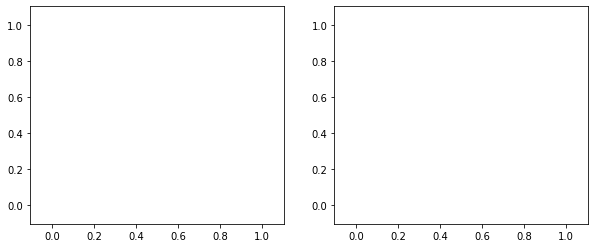

In [64]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for ax, sid in zip(axes, names):
    fp = ui.get_fit_plot(sid)
    ax.errorbar(fp.dataplot.x, fp.dataplot.y, yerr=fp.dataplot.yerr, fmt='o')
    ax.plot(fp.modelplot.x, fp.modelplot.y)

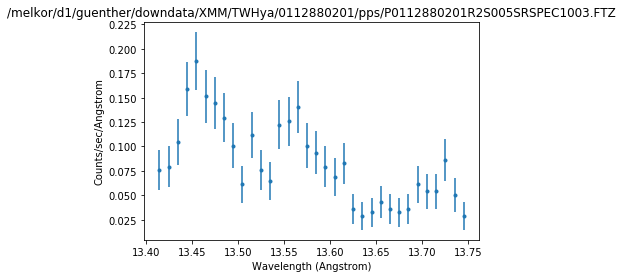

In [85]:
ui.notice(13.4, 13.75)
ui.ignore(None, 13.40)
ui.ignore(13.75, None)
#ui.plot_data('XMM_R1')
ui.plot_data('XMM_R2')

In [15]:
ui.set_method("levmar")
ui.set_stat("chi2gehrels")

In [16]:
#names= ['13250_leg+1', '13250_leg-1']
#names = ['7437_meg-1']
for n in names:
        ui.set_source(n, line_r + line_i + line_f)
        ui.group_width(n, 1)
        ui.group_counts(n, 5)
ui.fit(*names)
#ui.conf(*names)
#cov = ui.get_conf_results()

Datasets              = 'XMM_R1', 'XMM_R2'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 2660.39
Final fit statistic   = 2605.1 at function evaluation 8
Data points           = 792
Degrees of freedom    = 789
Probability [Q-value] = 1.67908e-192
Reduced statistic     = 3.30177
Change in statistic   = 55.2885
   r.norm         0.000271297  +/- 1.91799e-05 
   i.norm         0.00022276   +/- 1.87672e-05 
   f.norm         0.000101951  +/- 1.2729e-05  


In [18]:
names

['XMM_R1', 'XMM_R2']

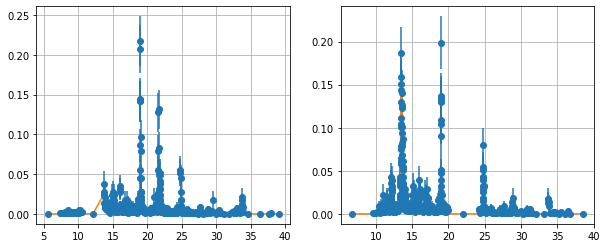

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for ax, sid in zip(axes, names):
    fp = ui.get_fit_plot(sid)
    ax.errorbar(fp.dataplot.x, fp.dataplot.y, yerr=fp.dataplot.yerr, fmt='o')
    ax.plot(fp.modelplot.x, fp.modelplot.y)
    ax.grid(True)

In [56]:
idnames = [['5_meg+1', '5_meg-1'],
           ['XMM_R2'],
           ['6443_leg+1', '6443_leg-1'],
           ['7435_meg+1', '7435_meg-1'],
           ['7436_meg+1', '7436_meg-1'],
           ['7437_meg+1', '7437_meg-1'],
           ['7438_meg+1', '7438_meg-1'],
           ['13250_leg+1',  '13250_leg-1'],
          ]
obsids = [o[0].split('_')[0] for o in idnames]

In [100]:
def fitlines(names):
    for n in names:
        ui.set_source(n, bkg + line_r + line_i + line_f)
        #ui.group_width(n, 1)
        #ui.group_counts(n, 5)
    ui.fit(*names)
    ui.conf(*names)
    cov = ui.get_conf_results()
    ui.plot_fit(names[0])
    ax = plt.gca()
    ax.set_title(names[0])
    return np.array([cov.parvals, cov.parmins, cov.parmaxes], dtype=np.floating), (plt.gcf(), ax)

Datasets              = '5_meg+1', '5_meg-1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 109.077
Final fit statistic   = 65.0581 at function evaluation 11
Data points           = 51
Degrees of freedom    = 47
Probability [Q-value] = 0.0415261
Reduced statistic     = 1.38421
Change in statistic   = 44.0191
   bkg.factor     8.53816e-07  +/- 1.8328e-07  
   r.norm         0.000138262  +/- 1.41782e-05 
   i.norm         9.22703e-05  +/- 1.24347e-05 
   f.norm         4.08298e-05  +/- 1.00476e-05 
bkg.factor lower bound:	-1.83277e-07
r.norm lower bound:	-1.41782e-05
bkg.factor upper bound:	1.83277e-07
i.norm lower bound:	-1.24347e-05
f.norm lower bound:	-1.00477e-05
r.norm upper bound:	1.41782e-05
i.norm upper bound:	1.24347e-05
f.norm upper bound:	1.00477e-05
Datasets              = '5_meg+1', '5_meg-1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence

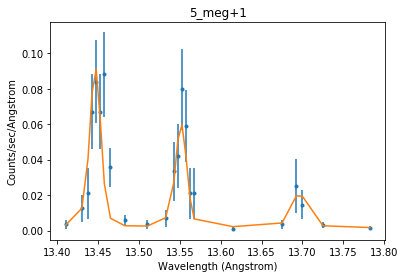

Dataset               = XMM_R2
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 138.877
Final fit statistic   = 33.1815 at function evaluation 11
Data points           = 36
Degrees of freedom    = 32
Probability [Q-value] = 0.40939
Reduced statistic     = 1.03692
Change in statistic   = 105.695
   bkg.factor     2.36098e-06  +/- 1.37954e-06 
   r.norm         0.000230094  +/- 2.94411e-05 
   i.norm         0.00017602   +/- 2.85494e-05 
   f.norm         4.54826e-05  +/- 2.60836e-05 
bkg.factor lower bound:	-1.37935e-06
bkg.factor upper bound:	1.37935e-06
r.norm lower bound:	-2.94396e-05
i.norm lower bound:	-2.85479e-05
r.norm upper bound:	2.94396e-05
i.norm upper bound:	2.85479e-05
f.norm lower bound:	-2.60818e-05
f.norm upper bound:	2.60818e-05
Dataset               = XMM_R2
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence 1-sigma (68.2689%) bounds:
  

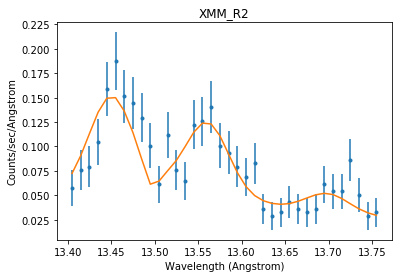

Datasets              = '6443_leg+1', '6443_leg-1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 181.214
Final fit statistic   = 125.25 at function evaluation 11
Data points           = 58
Degrees of freedom    = 54
Probability [Q-value] = 1.3724e-07
Reduced statistic     = 2.31944
Change in statistic   = 55.9645
   bkg.factor     3.78216e-06  +/- 5.88501e-07 
   r.norm         0.000214788  +/- 1.06869e-05 
   i.norm         0.000135732  +/- 9.55183e-06 
   f.norm         7.32046e-05  +/- 8.14319e-06 
bkg.factor lower bound:	-5.88574e-07
r.norm lower bound:	-1.0687e-05
i.norm lower bound:	-9.55186e-06
bkg.factor upper bound:	5.88574e-07
f.norm lower bound:	-8.14321e-06
r.norm upper bound:	1.0687e-05
i.norm upper bound:	9.55186e-06
f.norm upper bound:	8.14321e-06
Datasets              = '6443_leg+1', '6443_leg-1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels


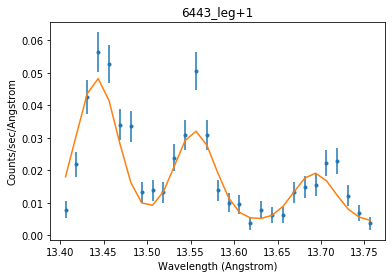

Datasets              = '7435_meg+1', '7435_meg-1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 2522.7
Final fit statistic   = 84.2207 at function evaluation 11
Data points           = 65
Degrees of freedom    = 61
Probability [Q-value] = 0.0261126
Reduced statistic     = 1.38067
Change in statistic   = 2438.48
   bkg.factor     3.33369e-07  +/- 7.68768e-08 
   r.norm         0.000127147  +/- 9.26618e-06 
   i.norm         9.7794e-05   +/- 7.80093e-06 
   f.norm         4.52275e-05  +/- 5.56502e-06 
bkg.factor lower bound:	-7.68916e-08
r.norm lower bound:	-9.26618e-06
i.norm lower bound:	-7.80093e-06
bkg.factor upper bound:	7.68916e-08
r.norm upper bound:	9.26618e-06
f.norm lower bound:	-5.56502e-06
i.norm upper bound:	7.80093e-06
f.norm upper bound:	5.56502e-06
Datasets              = '7435_meg+1', '7435_meg-1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels

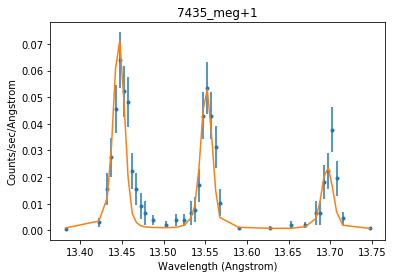

Datasets              = '7436_meg+1', '7436_meg-1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 144.991
Final fit statistic   = 102.803 at function evaluation 11
Data points           = 71
Degrees of freedom    = 67
Probability [Q-value] = 0.00322944
Reduced statistic     = 1.53437
Change in statistic   = 42.1883
   bkg.factor     3.63873e-07  +/- 7.5872e-08  
   r.norm         0.000189185  +/- 1.05074e-05 
   i.norm         0.000113092  +/- 8.51507e-06 
   f.norm         5.52966e-05  +/- 6.02354e-06 
bkg.factor lower bound:	-7.58666e-08
r.norm lower bound:	-1.05074e-05
bkg.factor upper bound:	7.58666e-08
i.norm lower bound:	-8.51507e-06
r.norm upper bound:	1.05074e-05
f.norm lower bound:	-6.02354e-06
i.norm upper bound:	8.51507e-06
f.norm upper bound:	6.02354e-06
Datasets              = '7436_meg+1', '7436_meg-1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehre

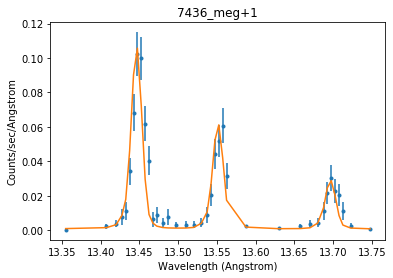

Datasets              = '7437_meg+1', '7437_meg-1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 118.333
Final fit statistic   = 82.5233 at function evaluation 11
Data points           = 67
Degrees of freedom    = 63
Probability [Q-value] = 0.0500415
Reduced statistic     = 1.30989
Change in statistic   = 35.81
   bkg.factor     6.2972e-07   +/- 1.07906e-07 
   r.norm         0.000138341  +/- 9.37684e-06 
   i.norm         9.95398e-05  +/- 8.25917e-06 
   f.norm         4.6364e-05   +/- 5.76303e-06 
bkg.factor lower bound:	-1.07915e-07
r.norm lower bound:	-9.37684e-06
bkg.factor upper bound:	1.07915e-07
i.norm lower bound:	-8.25917e-06
r.norm upper bound:	9.37684e-06
f.norm lower bound:	-5.76303e-06
i.norm upper bound:	8.25917e-06
f.norm upper bound:	5.76303e-06
Datasets              = '7437_meg+1', '7437_meg-1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels


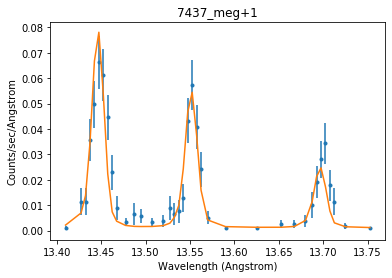

Datasets              = '7438_meg+1', '7438_meg-1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 22.5534
Final fit statistic   = 15.6435 at function evaluation 11
Data points           = 23
Degrees of freedom    = 19
Probability [Q-value] = 0.680913
Reduced statistic     = 0.823344
Change in statistic   = 6.90987
   bkg.factor     2.84053e-07  +/- 1.63786e-07 
   r.norm         0.000186463  +/- 3.53338e-05 
   i.norm         0.00012993   +/- 3.01733e-05 
   f.norm         4.07901e-05  +/- 1.94812e-05 
bkg.factor lower bound:	-1.63749e-07
r.norm lower bound:	-3.53338e-05
bkg.factor upper bound:	1.63749e-07
i.norm lower bound:	-3.01733e-05
r.norm upper bound:	3.53338e-05
f.norm lower bound:	-1.94812e-05
i.norm upper bound:	3.01733e-05
f.norm upper bound:	1.94812e-05
Datasets              = '7438_meg+1', '7438_meg-1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrel

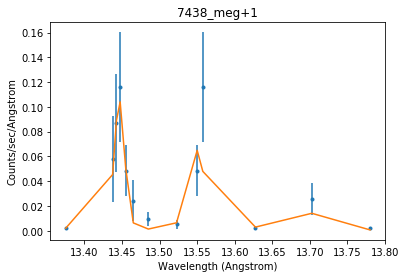

Datasets              = '13250_leg+1', '13250_leg-1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 33.9847
Final fit statistic   = 24.854 at function evaluation 11
Data points           = 35
Degrees of freedom    = 31
Probability [Q-value] = 0.774212
Reduced statistic     = 0.801741
Change in statistic   = 9.13072
   bkg.factor     9.3839e-07   +/- 4.29916e-07 
   r.norm         0.000224938  +/- 2.63224e-05 
   i.norm         0.000100674  +/- 1.93558e-05 
   f.norm         6.11773e-05  +/- 1.64136e-05 
bkg.factor lower bound:	-4.29949e-07
r.norm lower bound:	-2.63224e-05
bkg.factor upper bound:	4.29949e-07
i.norm lower bound:	-1.93558e-05
r.norm upper bound:	2.63224e-05
f.norm lower bound:	-1.64136e-05
i.norm upper bound:	1.93558e-05
f.norm upper bound:	1.64136e-05
Datasets              = '13250_leg+1', '13250_leg-1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2geh

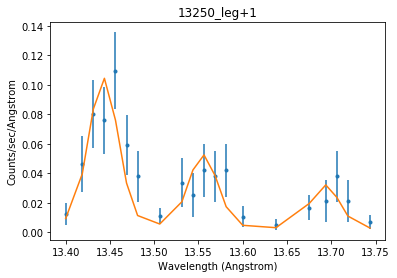

In [103]:
# Ne IX
line_r.LineE = 0.9220
line_i.LineE = 0.9148
line_f.LineE = 0.9051

ui.ignore(None, 13.40)
ui.ignore(13.75, None)
ui.notice(13.40, 13.75)

fits = []
plots = []
for n in idnames:
    f, p = fitlines(n)
    fits.append(f)
    plots.append(p)
    plt.show()

In [99]:
for p in plots:


AttributeError: 'AxesSubplot' object has no attribute 'show'

In [88]:
farr = np.stack(fits)

farr.shape

(8, 3, 4)

In [89]:
f2i = farr[:, 0, 3] / farr[:, 0, 2]
sig_f2i = np.sqrt((farr[:, 2, 3] / farr[:, 0, 2])**2 + (farr[:, 0, 3] * farr[:, 2, 2] / farr[:, 0, 2]**2)**2)

In [90]:
fi2r = (farr[:, 0, 3] + farr[:, 0, 2]) / farr[:, 0, 1]
sig_fi2r = np.sqrt((farr[:, 2, 3] / farr[:, 0, 1])**2 + 
                   (farr[:, 2, 2] / farr[:, 0, 1])**2 + 
                   ((farr[:, 0, 3] + farr[:, 0, 2]) * farr[:, 2, 1] / farr[:, 0, 1]**2)**2)

<ErrorbarContainer object of 3 artists>

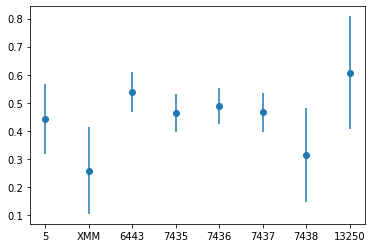

In [91]:
plt.errorbar(obsids, f2i, yerr=sig_f2i, fmt='o')

<ErrorbarContainer object of 3 artists>

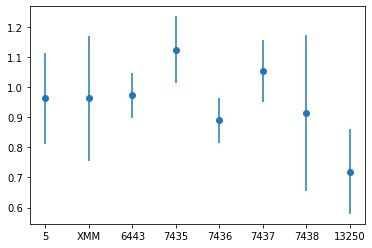

In [92]:
plt.errorbar(obsids, fi2r, yerr=sig_fi2r, fmt='o')